In [1]:
import time
from ML4transients.data_access import DatasetLoader
from ML4transients.training import PytorchDataset

# Load the dataset (should now load index from disk)
print("Loading dataset...")
t0 = time.time()
dataset = DatasetLoader('/sps/lsst/groups/transients/HSC/fouchez/raphael/data/UDEEP_norm')
print(f"Dataset loaded in {time.time() - t0:.2f} seconds")

2025-08-14 19:37:30.410654: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-14 19:37:30.427218: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755193050.447779 2347465 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755193050.454002 2347465 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755193050.470288 2347465 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

2025-08-14 19:37:30.410654: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-14 19:37:30.427218: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755193050.447779 2347465 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755193050.454002 2347465 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755193050.470288 2347465 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Loading dataset...
Dataset loaded in 0.14 seconds


Loading cutouts from visit 274
Visualizing cutouts for IDs: [117789478092801 117789478092802 117789478092803 117789478092804
 117789478092805 117789478092806]


Loading cutouts from visit 274
Visualizing cutouts for IDs: [117789478092801 117789478092802 117789478092803 117789478092804
 117789478092805 117789478092806]


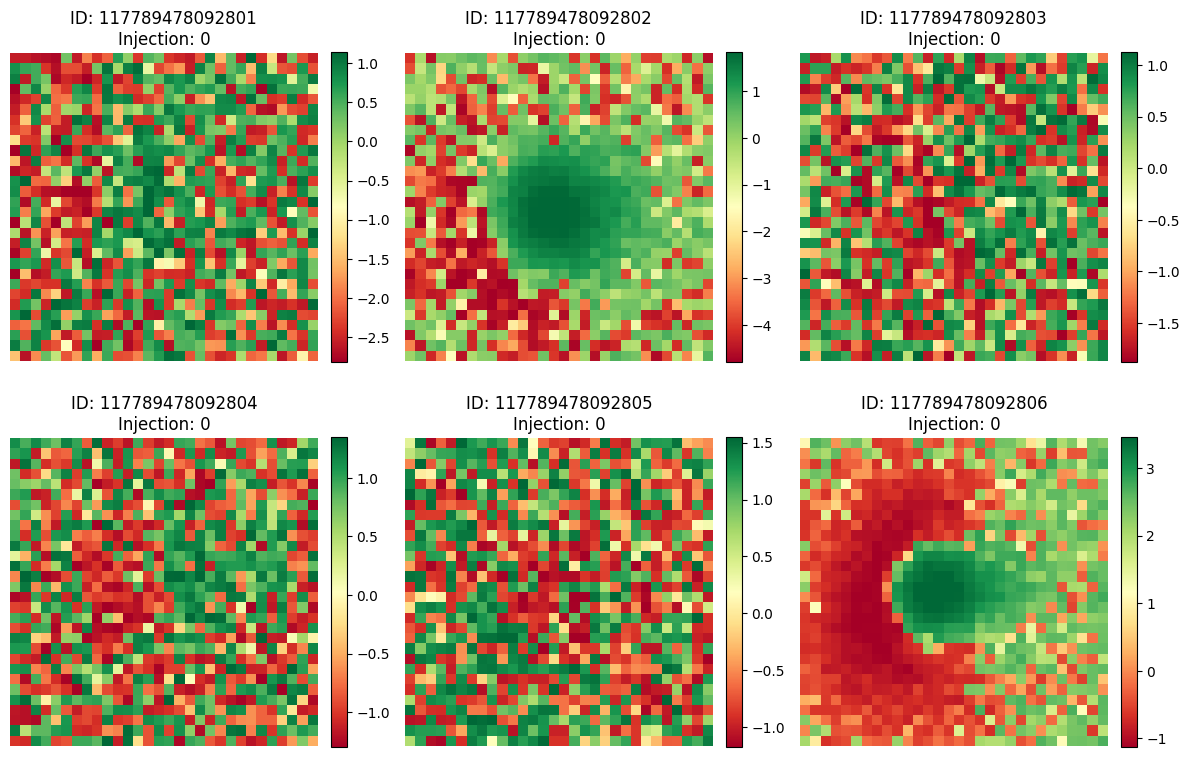

Cutout shape: (30, 30)
Cutout data type: float64
Cutout value range: [-1.128, 3.455]


In [2]:
# Visualize some cutouts
import matplotlib.pyplot as plt
import numpy as np

# Get a few sample IDs from the first visit
first_visit = dataset.visits[0]
print(f"Loading cutouts from visit {first_visit}")

# Get the cutout loader for the first visit
cutout_loader = dataset.cutouts[first_visit]
feature_loader = dataset.features[first_visit]

# Get first 6 IDs
sample_ids = cutout_loader.ids[:6]
print(f"Visualizing cutouts for IDs: {sample_ids}")

# Create a 2x3 subplot
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, dia_id in enumerate(sample_ids):
    # Get cutout and label
    cutout = cutout_loader.get_by_id(dia_id)
    features = feature_loader.get_by_id(dia_id)
    is_injection = features['is_injection'].iloc[0] if not features.empty else False
    
    # Display cutout (assuming it's a 2D array)
    im = axes[i].imshow(cutout, cmap='RdYlGn', origin='lower')
    axes[i].set_title(f'ID: {dia_id}\nInjection: {is_injection}')
    axes[i].axis('off')
    
    # Add colorbar
    plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

print(f"Cutout shape: {cutout.shape}")
print(f"Cutout data type: {cutout.dtype}")
print(f"Cutout value range: [{cutout.min():.3f}, {cutout.max():.3f}]")

Testing with diaSourceId: 117789478092811
Current global index status: True
Number of lightcurve loaders: 1

Complete lightcurve data retrieval took: 37.62 seconds
Object 3495980783397502987 has 169 sources
Cutouts: 169, Features: 169

Complete lightcurve data retrieval took: 37.62 seconds
Object 3495980783397502987 has 169 sources
Cutouts: 169, Features: 169


Testing with diaSourceId: 117789478092811
Current global index status: True
Number of lightcurve loaders: 1

Complete lightcurve data retrieval took: 37.62 seconds
Object 3495980783397502987 has 169 sources
Cutouts: 169, Features: 169

Complete lightcurve data retrieval took: 37.62 seconds
Object 3495980783397502987 has 169 sources
Cutouts: 169, Features: 169


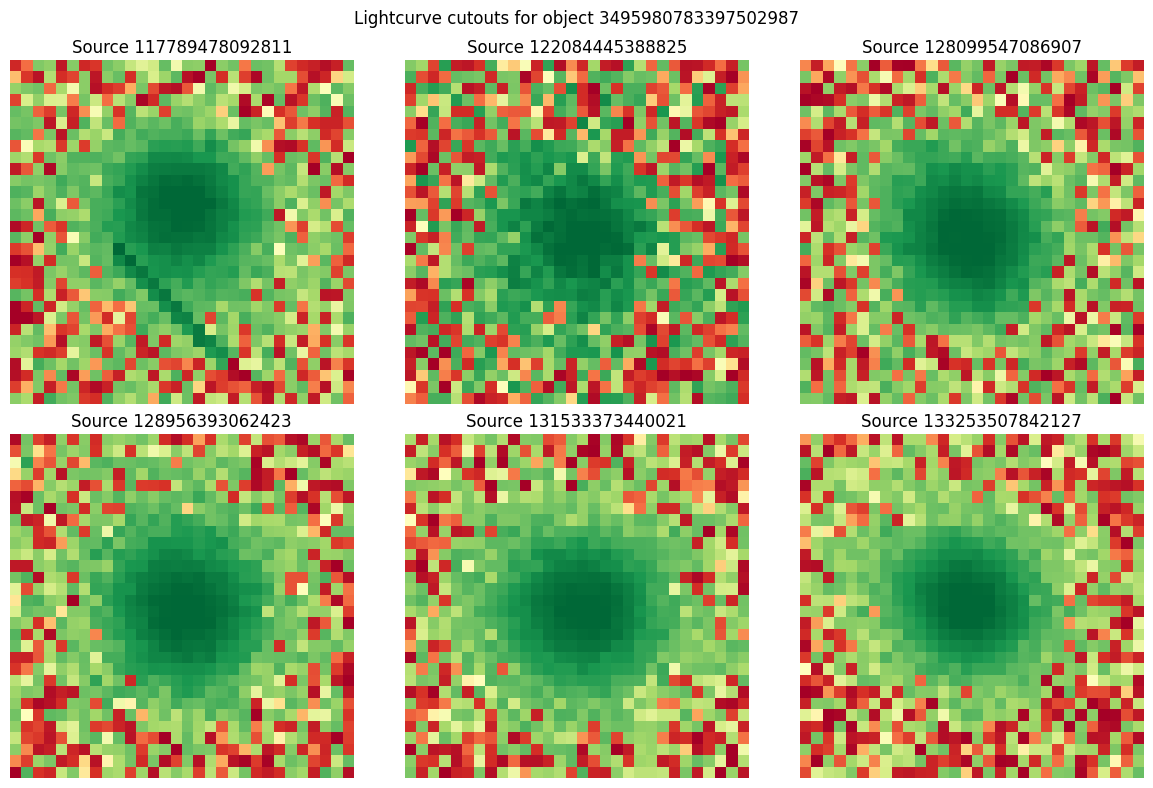

Plotting took: 0.65 seconds


In [4]:
# Test the complete lightcurve data function
first_visit = dataset.visits[0]
sample_dia_source_id = dataset.cutouts[first_visit].ids[10]

print(f"Testing with diaSourceId: {sample_dia_source_id}")

complete_data = dataset.get_complete_lightcurve_data(sample_dia_source_id)

if complete_data:
    print(f"Object {complete_data['object_id']} has {complete_data['num_sources']} sources")
    print(f"Cutouts: {len(complete_data['cutouts'])}, Features: {len(complete_data['features'])}")
    
    if complete_data['cutouts']:
        cutouts = complete_data['cutouts']
        n_cutouts = min(6, len(cutouts))
        
        fig, axes = plt.subplots(2, 3, figsize=(12, 8))
        axes = axes.flatten()
        
        for i, (src_id, cutout) in enumerate(list(cutouts.items())[:n_cutouts]):
            axes[i].imshow(cutout, cmap='RdYlGn', origin='lower')
            axes[i].set_title(f'Source {src_id}')
            axes[i].axis('off')
        
        for i in range(n_cutouts, 6):
            axes[i].set_visible(False)
        
        plt.suptitle(f'Lightcurve cutouts for object {complete_data["object_id"]}')
        plt.tight_layout()
        plt.show()
else:
    print("No lightcurve data found")